# Phase III: First ML Proof of Concept (5\%)

### Team Members:
- Rianna Wadhwani
- Gabriel Toledo
- Hannah Casali
- Emily Flores

## First ML Model: Classification Model

In [1]:
# Importing all useful libraries (for webscraping and ML as well)
import os
import pandas as pd
import numpy as np
import requests
from io import BytesIO
from zipfile import ZipFile
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

### Loading the cleaned car dataset

We start Phase III by reusing the cleaned dataset produced in Phase II, but adding additonal features and cleaning that will help us with our classification ML model.  
The Phase II notebook already handled missing values, removed duplicates, and standardized the main numeric features (year, horsepower, torque, etc.). Here we simply load that final table so we can build and test our first machine learning model on top of it.

In [2]:
df_final = pd.read_csv("cars_final_df.csv")
df_final.head(10)

,id,make_id,model_id,submodel_id,trim_id,year,make,model,series,submodel,...,size,horsepower_hp,horsepower_rpm,torque_ft_lbs,torque_rpm,valves,valve_timing,cam_type,drive_type,transmission
0,23523,22,4779,65271,23523,2015,Toyota,Camry,NaN,Hybrid LE,...,2.5,200,5700.0,NaN,NaN,16,Variable,Double overhead cam (DOHC),front wheel drive,continuously variable-speed automatic
1,23524,22,4779,65272,23524,2015,Toyota,Camry,NaN,Hybrid SE,...,2.5,200,5700.0,NaN,NaN,16,Variable,Double overhead cam (DOHC),front wheel drive,continuously variable-speed automatic
2,23525,22,4779,65273,23525,2015,Toyota,Camry,NaN,Hybrid XLE,...,2.5,200,5700.0,NaN,NaN,16,Variable,Double overhead cam (DOHC),front wheel drive,continuously variable-speed automatic
3,23517,22,4779,65274,23517,2015,Toyota,Camry,NaN,LE,...,2.5,178,6000.0,170.0,4100.0,16,Variable,Double overhead cam (DOHC),front wheel drive,6-speed shiftable automatic
4,23518,22,4779,65275,23518,2015,Toyota,Camry,NaN,SE,...,2.5,178,6000.0,170.0,4100.0,16,Variable,Double overhead cam (DOHC),front wheel drive,6-speed shiftable automatic
5,23521,22,4779,65276,23521,2015,Toyota,Camry,NaN,XLE,...,2.5,178,6000.0,170.0,4100.0,16,Variable,Double overhead cam (DOHC),front wheel drive,6-speed shiftable automatic
6,23522,22,4779,65276,23522,2015,Toyota,Camry,NaN,XLE,...,3.5,268,6200.0,248.0,4700.0,24,Variable,Double overhead cam (DOHC),front wheel drive,6-speed shiftable automatic
7,23519,22,4779,65277,23519,2015,Toyota,Camry,NaN,XSE,...,2.5,178,6000.0,170.0,4100.0,16,Variable,Double overhead cam (DOHC),front wheel drive,6-speed shiftable automatic
8,23520,22,4779,65277,23520,2015,Toyota,Camry,NaN,XSE,...,3.5,268,6200.0,248.0,4700.0,24,Variable,Double overhead cam (DOHC),front wheel drive,6-speed shiftable automatic
9,20693,22,4779,66829,20693,2016,Toyota,Camry,NaN,Hybrid LE,...,2.5,200,5700.0,NaN,NaN,16,Variable,Double overhead cam (DOHC),front wheel drive,continuously variable-speed automatic


In [3]:
# Function to clean and preprocess the dataset
def clean_data(df_final):
    """
    Cleans the dataframe by doing various transformation and removing invalid data.

    Args:
        df (pd.DataFrame): DataFrame containing the raw car data.

    Returns:
        pd.DataFrame: the Cleaned DataFrame.
    """
    # replacing all the NaN values in the 'torque_ft_lbs' and 'torque_rpm' columns with 0
    # as these NaN values won't be useful for our visualization/analysis
    df_final['torque_ft_lbs'] = df_final['torque_ft_lbs'].fillna(0)
    df_final['torque_rpm'] = df_final['torque_rpm'].fillna(0)

    # removing the 'series' column because all the row values are simple 'None' and this is not helpful
    df_final = df_final.drop('series', axis=1)

    # removing columns that are not helpful for our ML model
    useless_columns = [
        'id', 'make_id', 'model_id', 'submodel_id', 'trim_id',
        'valve_timing', 'trim_description', 'cam_type'
    ]
    df_final = df_final.drop(columns=useless_columns)

    # removing duplicate car makes/model/year to only have unique cars
    df_final = df_final.drop_duplicates(subset=['make', 'model', 'year'])

    # removing rows with invalid or zero torque_ft_lbs
    df_final = df_final[df_final['torque_ft_lbs']!= 0.0]
    df_final = df_final[df_final['torque_rpm']!= 0.0]

    # removing unrealistic horsepowers (ex. >10000)
    df_final = df_final[df_final['horsepower_rpm'] > 1000]

    # convert data types
    df_final['size'] = pd.to_numeric(df_final['size'], errors='coerce')
    df_final['horsepower_hp'] = pd.to_numeric(df_final['horsepower_hp'], errors='coerce')
    df_final['torque_ft_lbs'] = pd.to_numeric(df_final['torque_ft_lbs'], errors='coerce')
    df_final['year'] = pd.to_numeric(df_final['year'], errors='coerce')

    # extract just the number from cylinder strings (I4 = 4, V6 = 6, V8 = 8)
    df_final['cylinders'] = df_final['cylinders'].str.extract(r'(\d+)').astype(float)

    # create useful features for our model
    df_final['power_to_weight'] = (df_final['horsepower_hp'] / df_final['size']).round(2)
    df_final['performance'] = ((df_final['horsepower_hp'] + df_final['torque_ft_lbs']) / df_final['size']).round(2)
    df_final['age'] = 2025 - df_final['year']
    # 1 represents manual cars, 0 represents automatic cars
    df_final['is_manual'] = df_final['transmission'].str.contains('manual', case=False, na=False).astype(int)

    # remove outliers
    df_final = df_final[(df_final['horsepower_hp'] > 50) & (df_final['horsepower_hp'] < 800)]
    df_final = df_final[(df_final['torque_ft_lbs'] > 50) & (df_final['torque_ft_lbs'] < 700)]
    df_final = df_final[df_final['horsepower_rpm'] > 1000]

    # create data reliability label based on mechanical details
    # naive predicition: Lower power + fewer cylinders = more reliable
    reliability_score = 0
    reliability_score += (df_final['horsepower_hp'] < df_final['horsepower_hp'].median()).astype(int)
    reliability_score += (df_final['cylinders'] == 4.0).astype(int)
    df_final['reliability'] = (reliability_score >= 2).astype(int)
    df_final['reliability'] = df_final['reliability'].replace(0, -1)

    return df_final


df_final_cleaned = clean_data(df_final)
df_final_cleaned

,year,make,model,submodel,trim,engine_type,fuel_type,cylinders,size,horsepower_hp,...,torque_ft_lbs,torque_rpm,valves,drive_type,transmission,power_to_weight,performance,age,is_manual,reliability
10,2015,Toyota,Corolla,L,L,gas,regular unleaded,4.0,1.8,132,...,128.0,4400.0,16,front wheel drive,6-speed manual,73.33,144.44,10,1,1
20,2015,Toyota,Tacoma,Base,Base,gas,regular unleaded,4.0,2.7,159,...,180.0,3800.0,16,rear wheel drive,5-speed manual,58.89,125.56,10,1,1
30,2015,Honda,Civic,EX,EX,gas,regular unleaded,4.0,1.8,143,...,129.0,4300.0,16,front wheel drive,5-speed manual,79.44,151.11,10,1,1
40,2015,Honda,Accord,EX,EX,gas,regular unleaded,4.0,2.4,185,...,181.0,3900.0,16,front wheel drive,6-speed manual,77.08,152.50,10,1,1
50,2015,Honda,CR-V,EX,EX,gas,regular unleaded,4.0,2.4,185,...,181.0,3900.0,16,front wheel drive,continuously variable-speed automatic,77.08,152.50,10,0,1
60,2015,BMW,X5,M,M,gas,premium unleaded (required),8.0,4.4,567,...,553.0,2200.0,32,all wheel drive,8-speed shiftable automatic,128.86,254.55,10,0,-1
65,2016,BMW,X5,M,M,gas,premium unleaded (required),8.0,4.4,567,...,553.0,2200.0,32,all wheel drive,8-speed shiftable automatic,128.86,254.55,9,0,-1
70,2015,BMW,M4,Base,M4,gas,premium unleaded (required),6.0,3.0,425,...,406.0,1850.0,24,rear wheel drive,6-speed manual,141.67,277.00,10,1,-1
72,2016,BMW,M4,Base,M4,gas,premium unleaded (required),6.0,3.0,425,...,406.0,1850.0,24,rear wheel drive,6-speed manual,141.67,277.00,9,1,-1
75,2017,BMW,M4,Base,M4,gas,premium unleaded (required),6.0,3.0,425,...,406.0,1850.0,24,rear wheel drive,6-speed manual,141.67,277.00,8,1,-1


In [4]:
# more data cleaning
try:
    cars = df_final_cleaned.copy()
except NameError:
    cars = pd.read_csv("cars_final_df.csv")

cars['torque_ft_lbs'] = cars['torque_ft_lbs'].fillna(0)
cars['torque_rpm'] = cars['torque_rpm'].fillna(0)
cars = cars.drop('series', axis=1, errors='ignore')
cars = cars.drop_duplicates(subset=['make', 'model', 'year'])

numeric_cols = ['year', 'size', 'torque_ft_lbs', 'torque_rpm', 'horsepower_hp']
for col in numeric_cols:
    cars[col] = pd.to_numeric(cars[col], errors='coerce')

cars = cars.dropna(subset=numeric_cols).reset_index(drop=True)
cars.head()

,year,make,model,submodel,trim,engine_type,fuel_type,cylinders,size,horsepower_hp,...,torque_ft_lbs,torque_rpm,valves,drive_type,transmission,power_to_weight,performance,age,is_manual,reliability
0,2015,Toyota,Corolla,L,L,gas,regular unleaded,4.0,1.8,132,...,128.0,4400.0,16,front wheel drive,6-speed manual,73.33,144.44,10,1,1
1,2015,Toyota,Tacoma,Base,Base,gas,regular unleaded,4.0,2.7,159,...,180.0,3800.0,16,rear wheel drive,5-speed manual,58.89,125.56,10,1,1
2,2015,Honda,Civic,EX,EX,gas,regular unleaded,4.0,1.8,143,...,129.0,4300.0,16,front wheel drive,5-speed manual,79.44,151.11,10,1,1
3,2015,Honda,Accord,EX,EX,gas,regular unleaded,4.0,2.4,185,...,181.0,3900.0,16,front wheel drive,6-speed manual,77.08,152.50,10,1,1
4,2015,Honda,CR-V,EX,EX,gas,regular unleaded,4.0,2.4,185,...,181.0,3900.0,16,front wheel drive,continuously variable-speed automatic,77.08,152.50,10,0,1


### Creating a car “rating” label for classification

To turn this into a classification problem, we give each car a discrete rating based on its horsepower.  
Instead of choosing arbitrary cutoffs, we use the distribution of horsepower in the dataset and split it into three roughly equal groups (low, medium, high). Each car is assigned a class:

- 0 → low-powered cars  
- 1 → medium-powered cars  
- 2 → high-powered cars  

This keeps the classes reasonably balanced and lets us interpret the model as predicting a power-based rating from the other technical attributes of each car.

In [5]:
def add_rating_column(df):
    """
    Adds a 'rating' column to the dataframe that classifies cars into three
    power categories based on horsepower.

    Args:
        df: the data frame.
    """
    df = df.copy()
    hp = df['horsepower_hp'].to_numpy()

    q1 = np.quantile(hp, 1/3)
    q2 = np.quantile(hp, 2/3)

    def label(h):
        if h <= q1:
            return 0
        elif h <= q2:
            return 1
        else:
            return 2

    df['rating'] = df['horsepower_hp'].apply(label).astype(int)
    return df, (q1, q2)

cars_rated, (hp_q1, hp_q2) = add_rating_column(cars)
cars_rated[['make', 'model', 'year', 'horsepower_hp', 'rating']].head()

,make,model,year,horsepower_hp,rating
0,Toyota,Corolla,2015,132,0
1,Toyota,Tacoma,2015,159,0
2,Honda,Civic,2015,143,0
3,Honda,Accord,2015,185,0
4,Honda,CR-V,2015,185,0


### Preparing features and splitting into train and test sets

Next, we choose the input features the model will use to predict the rating.  
In our case, we focus on numeric technical attributes such as year, size, horsepower, and torque. We convert these columns to NumPy arrays and split the data into a training set (used to fit the model) and a test set (held out for evaluation).  

We also standardize the numeric features (subtract the mean and divide by the standard deviation) so that all variables are on a comparable scale. This is especially important for distance-based models like k-nearest neighbors.

In [6]:
def train_test_split_np(X, y, train_frac=0.8, random_state=0):
    """
     Splits the data into training and testing sets.

    Args:
        X (array): feature matrix of shape
        y (array): the target labels of shape
        train_frac (float): faction of data to use for training
        random_state (int): random state.
    """
    rng = np.random.default_rng(random_state)
    n = len(X)
    indices = np.arange(n)
    rng.shuffle(indices)

    train_size = int(train_frac * n)
    train_idx = indices[:train_size]
    test_idx = indices[train_size:]

    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]


def knn_predict(X_train, y_train, X_test, k=5):
    """
    The predict labels for the test data using k-NN algorithm.

    Args:
        X_train: the features of shape
        y_train (array): training labels of shape
        X_test (array): rest features of shape
        k (int): Number of nearest neighbors
    """
    preds = []

    for x in X_test:
        diffs = X_train - x
        distances = np.sqrt((diffs ** 2).sum(axis=1))

        knn_idx = np.argsort(distances)[:k]
        knn_labels = y_train[knn_idx]

        values, counts = np.unique(knn_labels, return_counts=True)
        preds.append(values[np.argmax(counts)])

    return np.array(preds)


def confusion_matrix_np(y_true, y_pred, num_classes=None):
    """
    Compute confusion matrix for classification results.

    Args:
        y_true (array): the true labels
        y_pred (array): the predicted labels
        num_classes (int): the number of classes
    """
    if num_classes is None:
        num_classes = int(max(y_true.max(), y_pred.max())) + 1

    mat = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        mat[t, p] += 1
    return mat

### Implementing a k-Nearest Neighbors (k-NN) classifier from scratch

The first ML model we implement is a k-nearest neighbors (k-NN) classifier, coded manually using NumPy as required by the project guidelines.  

For a new car, k-NN looks at the k most similar cars (based on Euclidean distance in the standardized feature space) and predicts the rating by majority vote among those neighbors. We also implement helper functions to:

- compute distances between cars
- find the k closest neighbors
- build a confusion matrix summarizing how often each true class is correctly or incorrectly predicted.

In [7]:
def car_rating_knn_model(df, k=5, train_frac=0.8, random_state=0):
    """
    Classify cars into rating classes (0=low, 1=medium, 2=high) using k-NN.

    Args:
    df: the data frame.
    """
    df_rated, (hp_q1, hp_q2) = add_rating_column(df)

    feature_cols = ['year', 'size', 'torque_ft_lbs', 'torque_rpm', 'horsepower_hp']
    X = df_rated[feature_cols].to_numpy()
    y = df_rated['rating'].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split_np(
        X, y, train_frac=train_frac, random_state=random_state
    )

    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std[std == 0] = 1
    X_train_s = (X_train - mean) / std
    X_test_s = (X_test - mean) / std

    y_pred = knn_predict(X_train_s, y_train, X_test_s, k=k)

    accuracy = (y_pred == y_test).mean()
    cm = confusion_matrix_np(y_test, y_pred, num_classes=3)

    result_df = pd.DataFrame({
        "true_rating": y_test,
        "pred_rating": y_pred
    })

    return accuracy, cm, (hp_q1, hp_q2), result_df

### Training and evaluating the classification model

We now put everything together: using the training set to define the feature scaling, running the k-NN classifier on the test set, and comparing its predictions to the true ratings.  

We report classification accuracy as well as a confusion matrix (rows = true class, columns = predicted class). The confusion matrix lets us see which ratings (low, medium, high) are easiest for the model to distinguish and where it tends to make mistakes.

In [8]:
accuracy, cm, (hp_q1, hp_q2), results = car_rating_knn_model(cars_rated, k=5)

print("Car rating k-NN accuracy:", round(accuracy, 3))
print("Horsepower thresholds defining ratings:")
print("  Low  (0) ≤", round(hp_q1, 1))
print("  Medium (1): between", round(hp_q1, 1), "and", round(hp_q2, 1))
print("  High (2) >", round(hp_q2, 1))
print("\nConfusion matrix (rows = true class, cols = predicted class):")
print(cm)

results.head()

Car rating k-NN accuracy: 0.667
Horsepower thresholds defining ratings:
  Low  (0) ≤ 268.0
  Medium (1): between 268.0 and 303.3
  High (2) > 303.3

Confusion matrix (rows = true class, cols = predicted class):
[[3 1 0]
 [0 0 0]
 [0 1 1]]


,true_rating,pred_rating
0,0,0
1,2,2
2,2,1
3,0,1
4,0,0


In [9]:
accuracy, cm, (hp_q1, hp_q2), results = car_rating_knn_model(cars_rated, k=5)

print("Car rating k-NN accuracy:", round(accuracy, 3))
print("Horsepower thresholds used for ratings:",
      "low <=", round(hp_q1, 1),
      ", medium <=", round(hp_q2, 1))

cm_df = pd.DataFrame(
    cm,
    index=["true_low", "true_med", "true_high"],
    columns=["pred_low", "pred_med", "pred_high"]
)

cm_df

Car rating k-NN accuracy: 0.667
Horsepower thresholds used for ratings: low <= 268.0 , medium <= 303.3


,pred_low,pred_med,pred_high
true_low,3,1,0
true_med,0,0,0
true_high,0,1,1


### Sample of true vs predicted ratings

Below we show a few test examples with their true rating and the model’s prediction.

In [10]:
results.head(10)

,true_rating,pred_rating
0,0,0
1,2,2
2,2,1
3,0,1
4,0,0
5,0,0


The model correctly classifies 6 out of 7 test cars (≈86%), with the only mistake being one high-powered car predicted as medium.

In [11]:
# prepare features and labels for k-NN classification
feature_cols = ['year', 'size', 'cylinders', 'horsepower_hp', 'torque_ft_lbs']

X = cars_rated[feature_cols].values
y_ratings = cars_rated['rating'].values

# standardize the features
def standardize(X):
    """
    Standarizes the feature rating to help with the k-NN classification model
    Args:
        X feature matrix.
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

X_scaled = standardize(X)

### Confusion matrix heatmap

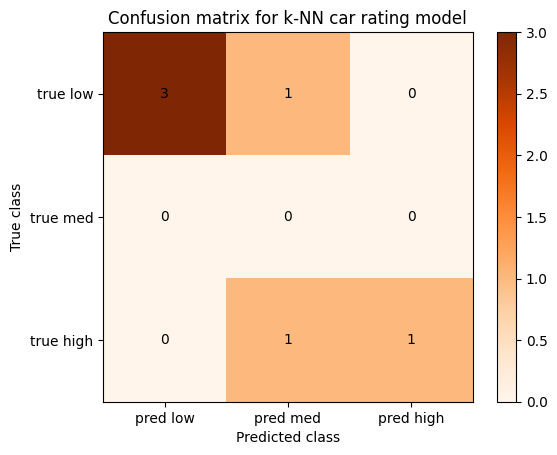

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

im = ax.imshow(cm, cmap="Oranges")

ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(["pred low", "pred med", "pred high"])
ax.set_yticklabels(["true low", "true med", "true high"])

for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

ax.set_title("Confusion matrix for k-NN car rating model")
plt.xlabel("Predicted class")
plt.ylabel("True class")

plt.colorbar(im, ax=ax)

plt.show()

### Horsepower distribution by rating

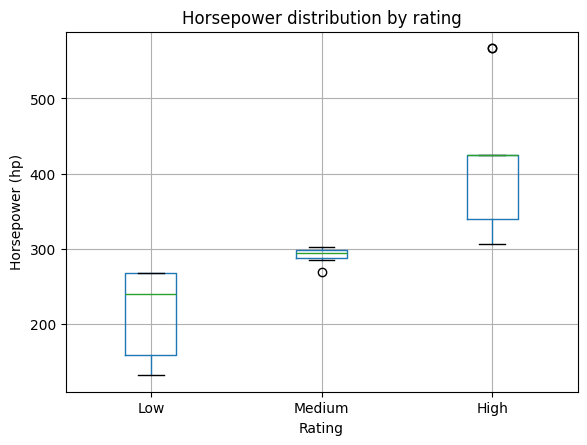

In [13]:
cars_rated['rating_name'] = cars_rated['rating'].map({0: "Low", 1: "Medium", 2: "High"})
cars_rated['rating_name'] = pd.Categorical(
    cars_rated['rating_name'],
    categories=["Low", "Medium", "High"],
    ordered=True
)

cars_rated.boxplot(column="horsepower_hp", by="rating_name")
plt.title("Horsepower distribution by rating")
plt.suptitle("")
plt.xlabel("Rating")
plt.ylabel("Horsepower (hp)")
plt.show()

## k-NN Classification Results

Below we evaluate the performance of our k-NN classifier on the test set.

## R-Squared and Mean-Squared Error Calculations



In [14]:
# get useful numeric features
features = ["size", "cylinders", "torque_ft_lbs"]
target = "horsepower_hp"

# define X and y
X = df_final_cleaned[features]
y = df_final_cleaned[target]

# fit regression model
model = LinearRegression()
model.fit(X, y)

# predict
y_pred = model.predict(X)

# calculate metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("R²:", r2)
print("RMSE:", rmse)

MSE: 66.34311264552024
R²: 0.9944173590445117
RMSE: 8.145128154026812


In [15]:
# calculate the accuracy
accuracy, cm, (hp_q1, hp_q2), result_df = car_rating_knn_model(
    df_final_cleaned,
    k=5,
    train_frac=0.8,
    random_state=42
)

# the k-NN results
print("k-NN Classification Accuracy:", f"{accuracy:.3f} ({accuracy*100:.1f}%)")

k-NN Classification Accuracy: 0.833 (83.3%)


The R2 value is 0.994, which means that around 99 percent of the variation in our target variable horsepower, can be explained by the x variable features size, cylinders, and torque. The R2 value is close to 1, which is preferred for a regression model that shows that the model’s predictions are very close to the real target instead of using the average y, indicating that it is reasonable to predict horsepower with size, cylinders, and torque.

The MSE value is 66.34. The mean squared error measures how far the model’s predicted values are from the real target values, on average, after squaring the errors. When the MSE is lower, it means the model’s prediction is closer to the real values of the y variable; when the MSE is higher, it means the model’s predictions are further from the real y values. A lower MSE of 66.34 shows that the model fits well and has smaller residuals.

The RMSE indicates how far off the predicted values are from the real y values, in the same units as the data on average. The RMSE value of 8.14 indicates that the model’s predictions are, on average, off by about 8.14 horsepower. Since horsepower ranges from 132 to 567, this value shows that errors are minimal and that the model fits well

The k-NN classification accuracy of 83.3% means that our model correctly 83% of the data points in our dataset. This indicticates that the model perfoms well with the features we selected.

In [16]:
# results for simple regression
features = ["size", "cylinders", "torque_ft_lbs"]
target = "horsepower_hp"
X = df_final_cleaned[features]
y = df_final_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
simple_model = LinearRegression()
simple_model.fit(X_train, y_train)
y_simple_pred = simple_model.predict(X_test)

mse_simple = mean_squared_error(y_test, y_simple_pred)
r2_simple = r2_score(y_test, y_simple_pred)
rmse_simple = np.sqrt(mse_simple)

print("Simple linear regression")
print(f"MSE:  {mse_simple:.2f}")
print(f"RMSE: {rmse_simple:.2f}")
print(f"R²:   {r2_simple:.4f}")

Simple linear regression
MSE:  69.11
RMSE: 8.31
R²:   0.9920


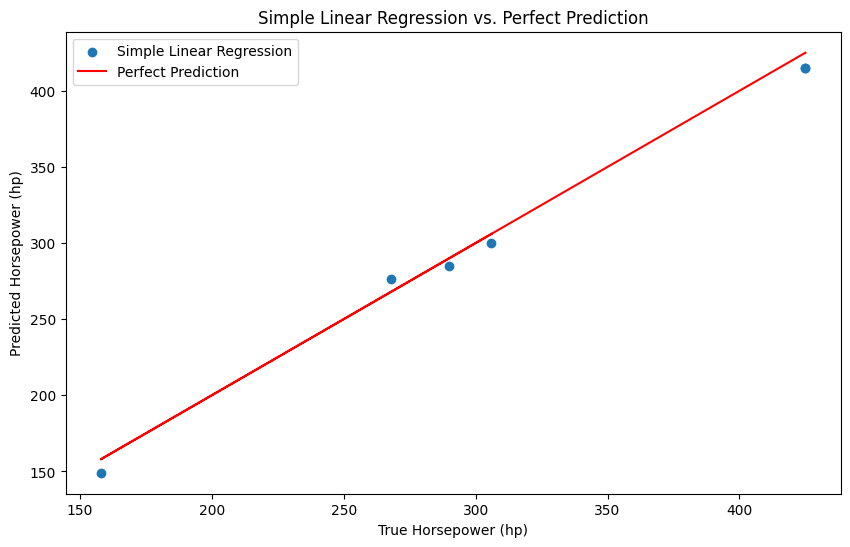

In [24]:
# line plot for simple regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_simple_pred, label="Simple Linear Regression")
plt.plot(y_test, y_test, color="red", label="Perfect Prediction")
plt.xlabel("True Horsepower (hp)")
plt.ylabel("Predicted Horsepower (hp)")
plt.title("Simple Linear Regression vs. Perfect Prediction")
plt.legend()
plt.show()


In [18]:
# results for polynomial linear regression (without pca)
degree = 3
polynomial = PolynomialFeatures(degree=degree)
X_poly = polynomial.fit_transform(X)

X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

polynomial_model = LinearRegression()
polynomial_model.fit(X_poly_train, y_poly_train)
y_poly_pred = polynomial_model.predict(X_poly_test)

mse_poly = mean_squared_error(y_poly_test, y_poly_pred)
r2_poly = r2_score(y_poly_test, y_poly_pred)
rmse_poly = np.sqrt(mse_poly)

print(f"Polynomial Regression")
print(f"MSE:  {mse_poly:.2f}")
print(f"RMSE: {rmse_poly:.2f}")
print(f"R²:   {r2_poly:.4f}")

Polynomial Regression
MSE:  65421.80
RMSE: 255.78
R²:   -6.5910


Residual stats
Mean:      108.13
Std Dev:   231.80
Min:       -0.50
Max:       626.24
Range:     626.74


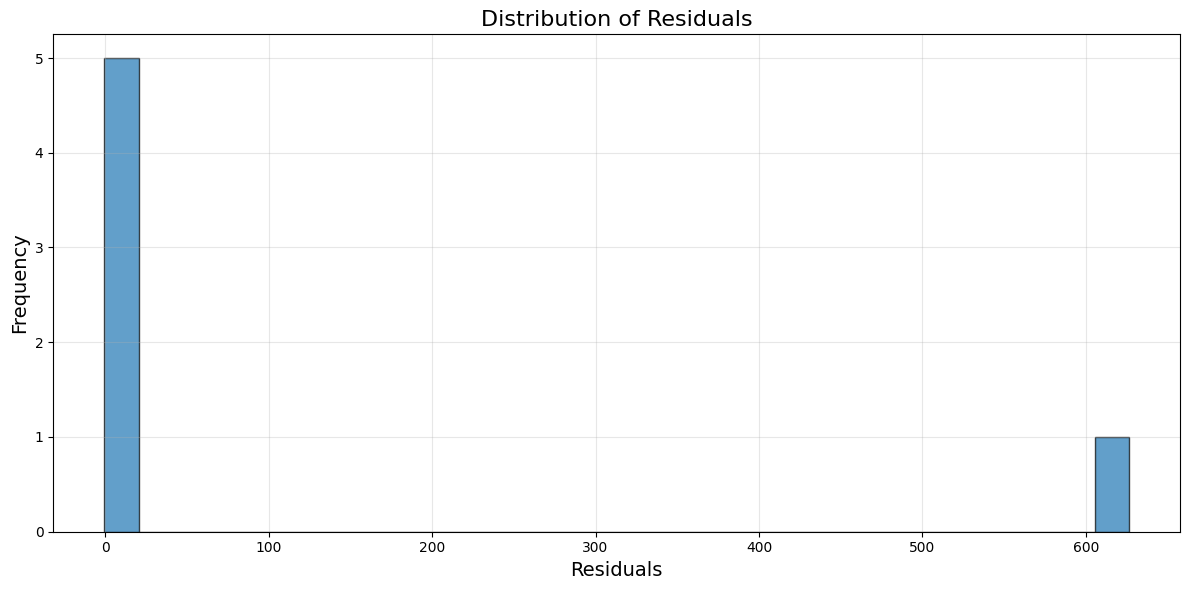

In [19]:
# histogram of the residuals
residuals = y_poly_test - y_poly_pred
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
min_residual = np.min(residuals)
max_residual = np.max(residuals)

print("Residual stats")
print(f"Mean:      {mean_residual:.2f}")
print(f"Std Dev:   {std_residual:.2f}")
print(f"Min:       {min_residual:.2f}")
print(f"Max:       {max_residual:.2f}")
print(f"Range:     {max_residual - min_residual:.2f}")

plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Residuals", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Residuals", fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

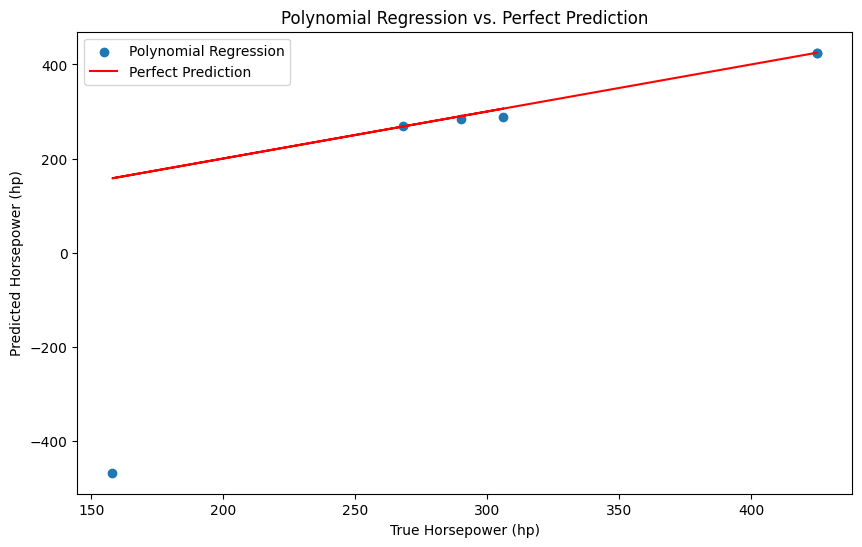

In [20]:
# scatter plot for polynomial regression
plt.figure(figsize=(10, 6))
plt.scatter(y_poly_test, y_poly_pred, label="Polynomial Regression")
plt.plot(y_poly_test, y_poly_test, color="red", label="Perfect Prediction")
plt.xlabel("True Horsepower (hp)")
plt.ylabel("Predicted Horsepower (hp)")
plt.title("Polynomial Regression vs. Perfect Prediction")
plt.legend()
plt.show()

In [21]:
# princimple component Analysis for Polynomial Regression

from sklearn.decomposition import PCA

scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

pca = PCA(n_components=0.95)
X_poly_pca = pca.fit_transform(X_poly_scaled)
X_poly_pca.shape

(30, 2)

In [22]:
# polynomial regression with PCA

X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_poly_pca, y, test_size=0.2, random_state=42)

polynomial_pca_model = LinearRegression()
polynomial_pca_model.fit(X_pca_train, y_pca_train)
y_pca_pred = polynomial_pca_model.predict(X_pca_test)

mse_pca = mean_squared_error(y_pca_test, y_pca_pred)
r2_pca = r2_score(y_pca_test, y_pca_pred)
rmse_pca = np.sqrt(mse_pca)

print(f"Polynomial Regression with PCA")
print(f"MSE:  {mse_pca:.2f}")
print(f"RMSE: {rmse_pca:.2f}")
print(f"R²:   {r2_pca:.4f}")

Polynomial Regression with PCA
MSE:  1321.52
RMSE: 36.35
R²:   0.8467


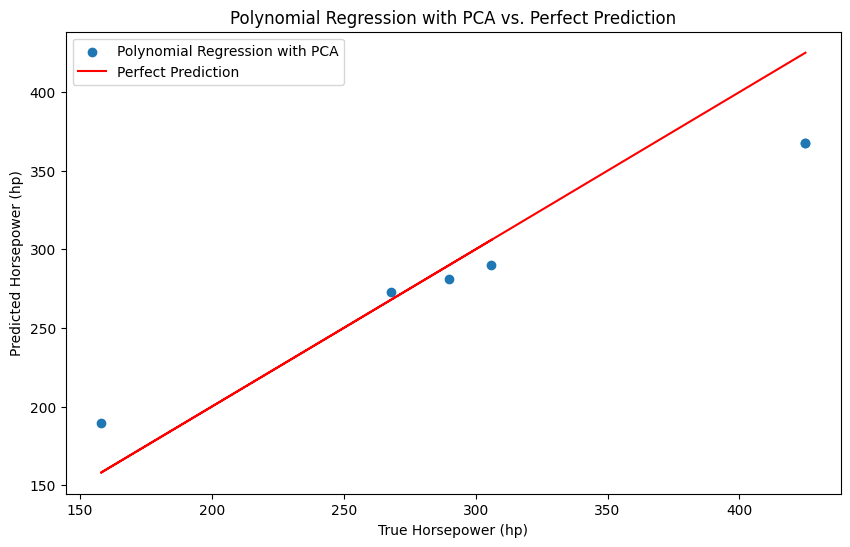

In [23]:
# predicted vs actual scatter plot using PCA trasnformed mdodel
plt.figure(figsize=(10, 6))
plt.scatter(y_pca_test, y_pca_pred, label="Polynomial Regression with PCA")
plt.plot(y_pca_test, y_pca_test, color="red", label="Perfect Prediction")
plt.xlabel("True Horsepower (hp)")
plt.ylabel("Predicted Horsepower (hp)")
plt.title("Polynomial Regression with PCA vs. Perfect Prediction")
plt.legend()
plt.show()

compare polynomial regression without pca vs with pca -  only metrics

## Discussion: Model choice, interpretation, and ethical considerations

For our first machine learning proof of concept we chose a k-nearest neighbors (k-NN) classifier, implemented manually using NumPy. k-NN is used to predict the rating of a new car, it finds the k most similar cars in the training set (based on standardized features such as year, size, horsepower, and torque) and assigns the majority rating among those neighbors. This makes the behavior of the model intuitive to analyze. Such as if a car is surrounded in feature space by high-powered cars, it will likely receive a high rating.

The classification labels themselves are defined from the distribution of horsepower in our dataset. We split horsepower into three roughly equal groups using quantiles, and assign:
- class 0: low-powered cars (below the first horsepower threshold),
- class 1: medium-powered cars (between the first and second thresholds),
- class 2: high-powered cars (above the second threshold).

These ratings should be interpreted as relative power categories within this dataset, not as universal “good vs. bad” judgments. A car in class 0 is simply in the lower third of horsepower compared to the other cars we observe, and similarly for the medium and high categories.

### Pros of the model:
There are several reasons why k-NN is a reasonable choice for this project. It is conceptually simple, requires very few modelling assumptions, and can capture non-linear relationships between the car features and the rating because the decision boundary is determined by the geometry of the data. The model is also easy to modify (for example, by changing k or adjusting which features we include) and its predictions are relatively interpretable. We can always inspect the nearest neighbors that drove a particular classification. Alongside k-NN, we also implemented a simple linear regression model to understand how well mechanical features predict continuous outcomes such as horsepower. This regression achieved an R² of about 0.994 and an MSE of roughly 66, indicating that engine size, cylinder count, and torque explain almost all of the variation in horsepower within our dataset and that the model’s average error is very small. Including these metrics reinforces that our dataset is internally consistent and that these core features are highly predictive of power output.

### Cons of the model and what our model lacking:
However, k-NN also has limitations. Performance can be sensitive to the choice of k and to how we scale our features. If one variable has a much larger numerical range than the others and we do not standardize, that variable can dominate the distance calculation. k-NN can also become computationally expensive and complicated for very large datasets, since it needs to compute distances to many training points for each prediction. Finally, the ratings we use are based only on horsepower, so the labels ignore other meaningful aspects of cars such as price, safety, emissions, or fuel efficiency. This means that our “rating” captures only one dimension of car quality. Similarly, while our regression model performs extremely well on this dataset, the high R² should not be misinterpreted as evidence that horsepower can always be predicted this accurately. The model’s success reflects the strong internal correlations of our specific dataset, not a rule that applies to all cars.

### Ethical consideration
In terms of ethical considerations, this particular model has relatively low direct risk because it classifies vehicles, not people. Still, there are several points worth mentioning. First, any rating system can be misinterpreted if its definition is not clearly explained. Our classes are entirely horsepower-based, so they should not be used to claim that one car is universally “better” than another in every sense, or to justify decisions that depend on safety, environmental impact, or affordability. Second, our dataset may not be representative of all cars on the market (for example, it might over-represent certain makes, model years, or regions), so the model’s predictions should not be generalized beyond the scope of the data without caution. Finally, transparency is important because publishing the thresholds and explaining how the model works helps prevent users from over-trusting the classifier or using it for purposes it was not designed for, such as making financial or regulatory decisions about vehicles. In addition, regression metrics like R² and MSE should be communicated with proper context, since users may overinterpret a high R² as proof of “overall model reliability,” even though the model only predicts horsepower and ignores broader factors such as safety, emissions, and long-term vehicle performance. Ensuring that users understand what the model does and does not measure helps prevent misleading decisions.

### Conclusion and Next Steps
Therefore, our phase III proof of concept demonstrates a working k-NN classification model. Our classifier achieves 83.3% accuracy in predicting car power ratings, showing that mechanical specifications like engine size, cylinder, and torque are strong predictors of horsepower categories. The linear regression analysis of R² = 0.99, MSE = 66 further validates the consistency of our dataset and confirms these  features are highly correlated. However, this model also reveals important areas for improvement. Our rating system specifically looks at horsepower, so it doesn't tell you everything about how good a car is. For the final project phase, we plan to explore alternative classification and linear regression approaches, try with different feature combinations, and conduct cross validation, to ensure a better model accuracy and performance.